## Coding Assignment 3

Team:
- Olivia Dalglish (od4)
- Arindam Saha (saha2)

Contribution: 

Olivia: Part 2 and 3

Arindam: Part 1

In addition to the above, we discussed our approaches and checked each other's work.

### Part I: Optimal Span for LOESS

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skmisc.loess import loess


In [2]:
myData = pd.read_csv("Coding3_Data.csv")
var_names = myData.columns
y = myData[['y']].to_numpy().flatten()
x = myData[['x']].to_numpy()
len(x), len(y)

(30, 30)

In [3]:
def smoother_matrix_diag(x, span):
    model = loess(x, np.zeros(len(x)), span=span)
    model.fit()
    return model.outputs.diagonal


def optimal_span(x, y, spans):
    cv_values = np.zeros(len(spans))
    gcv_values = np.zeros(len(spans))
    for idx, span in enumerate(spans):
        model = loess(x, y, span=span)
        model.fit()
        y_hat = model.predict(x).values
        
        s_diag = smoother_matrix_diag(x, span)
        cv = np.mean(((y - y_hat) / (1 - s_diag)) ** 2)
        gcv = np.mean(((y - y_hat) / (1 - np.mean(s_diag))) ** 2)

        cv_values[idx] = cv
        gcv_values[idx] = gcv

    return cv_values, gcv_values, spans[np.argmin(cv_values)], spans[np.argmin(gcv_values)]
    
spans = np.linspace(0.20, 0.90, 15)    

cv_values, gcv_values, cv_best_span, gcv_best_span = optimal_span(x, y, spans)

for span, cv_value, gcv_value in zip(spans, cv_values, gcv_values):
    print(f"span: {span} cv_value: {cv_value} gcv_values: {gcv_value}")

print(f"best span: cv {cv_best_span} gcv {gcv_best_span}")



span: 0.2 cv_value: 12.415910699871809 gcv_values: 2.110161841942955
span: 0.25 cv_value: 2.2414734958901503 gcv_values: 1.4892056326217187
span: 0.3 cv_value: 1.5029798111583694 gcv_values: 1.1901098446318226
span: 0.35 cv_value: 1.2591747084691491 gcv_values: 1.1744229564766888
span: 0.4 cv_value: 1.1903799279913367 gcv_values: 1.102539903823101
span: 0.44999999999999996 cv_value: 1.1568121230625683 gcv_values: 1.0625034645069498
span: 0.5 cv_value: 1.1243056621273273 gcv_values: 1.0404222708825768
span: 0.55 cv_value: 1.179663752374441 gcv_values: 1.1188405514998327
span: 0.6 cv_value: 1.179464162542817 gcv_values: 1.1192688072551902
span: 0.6499999999999999 cv_value: 1.2509138273813036 gcv_values: 1.180584776931384
span: 0.7 cv_value: 1.553562264253347 gcv_values: 1.5190908128135594
span: 0.75 cv_value: 1.6361746170729456 gcv_values: 1.6274293455726156
span: 0.8 cv_value: 1.764533626604454 gcv_values: 1.7445490858435333
span: 0.8499999999999999 cv_value: 1.9760935148587322 gcv_valu

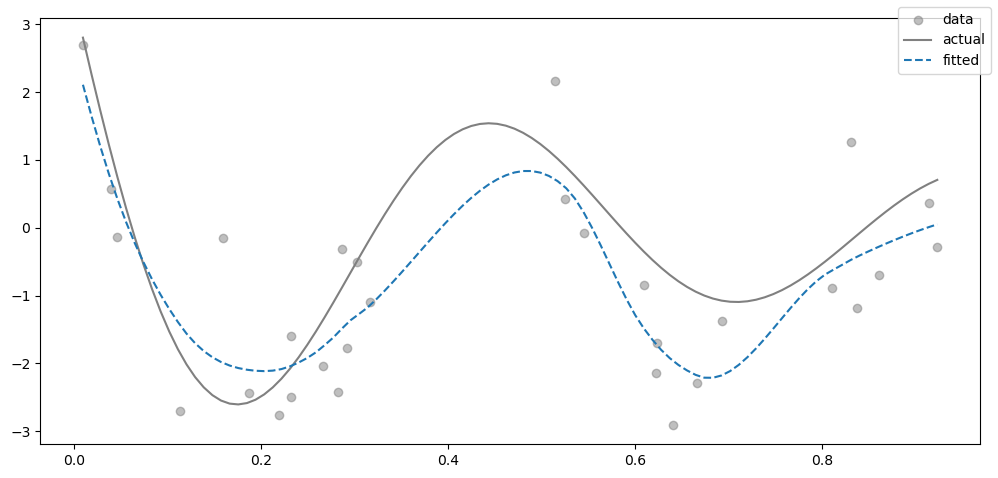

In [4]:
fig, axes = plt.subplots(nrows=1, ncols=1)

plot_x = np.linspace(np.min(x), np.max(x), 100)
smoothed = loess(x, y, span=cv_best_span).predict(plot_x).values

def actual_f(x):
    return np.sin(12 * (x + 0.2)) / (x + 0.2)

axes.scatter(x, y, marker='o', alpha=0.5, c='gray', label='data')
axes.plot(plot_x, actual_f(plot_x), c='gray', label='actual')
axes.plot(plot_x, smoothed, linestyle='--', label='fitted')
fig.set_figwidth(10)
fig.legend()
fig.tight_layout()
plt.show()

### Part II: Ridgeless and double descent